In [1]:
''' RNN Bidireccional en Keras '''
__author__ = '@Tssp'
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage
# Keras NN:
from keras.utils import to_categorical
# My utils:
from codvidutils.imageproc import map_categorical
from codvidutils.cudasession import set_session
from codvidutils import nwpic as nw

Using TensorFlow backend.


In [2]:
#set_session(ngpu=1, ncpu=4)
set_session()

Num GPUs Available:  2
Num CPUs Available:  7
---------Keras session created with---------
 - 2 GPUs
 - 7 CPUs


In [41]:
train_class = pd.read_csv('data/train_split_v3.csv', sep=' ', header=None, names=['patientID', 'image_path', 'class'])
test_class = pd.read_csv('data/test_split_v3.csv', sep=' ', header=None, names=['patientID', 'image_path', 'class'])

In [42]:
train_class

,patientID,image_path,class
NaN,patientID,image_path,class
0.0,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia
1.0,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia
2.0,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia
3.0,7,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia
4.0,7,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia
5.0,9,SARS-10.1148rg.242035193-g04mr34g07a-Fig7a-day...,pneumonia
6.0,9,SARS-10.1148rg.242035193-g04mr34g07b-Fig7b-day...,pneumonia
7.0,10,SARS-10.1148rg.242035193-g04mr34g09a-Fig9a-day...,pneumonia
8.0,10,SARS-10.1148rg.242035193-g04mr34g09b-Fig9b-day...,pneumonia


## Preparing the categorical variable (Y)

In [4]:
values_dict = {'pneumonia': 2, 'COVID-19': 1, 'normal': 0}
test_class['class_categorical'] = test_class['class'].apply(map_categorical, args=(values_dict,))
train_class['class_categorical'] = train_class['class'].apply(map_categorical, args=(values_dict,))
diseaseID_train = np.asarray(train_class["class_categorical"])
diseaseID_test = np.asarray(test_class["class_categorical"])
diseaseID = np.concatenate([diseaseID_train, diseaseID_test],axis=0)

## Reading the pictures

In [5]:
pics = []
for img in train_class['image_path'].values:
    pics.append(np.array(Image.open('data/train/' + img))[:, :,:3])
for img in test_class['image_path'].values:
    pics.append(np.array(Image.open('data/test/' + img))[:, :, :3])

print("Total number of images:", len(pics))
del train_class, test_class

Total number of images: 18527


In [6]:
X = np.array(pics)
del pics
print('shape X: {},  disease_ID (Y): {}'.format(X.shape, diseaseID.shape ))

shape X: (18527, 200, 200, 3),  disease_ID (Y): (18527,)


## Imablanced data

In [7]:
diseaseID, X = nw.underbalance_imgs(diseaseID, X)

Count of classes:  Counter({2: 9579, 0: 8851, 1: 97})
New diseaseID shape:  (9097,)
New X shape:  (9097, 120000)
New Count of classes:  Counter({0: 4500, 2: 4500, 1: 97})


In [8]:
n = np.random.randint(1000,6760)
print(n)
from sklearn.utils import shuffle
X, diseaseID = shuffle(X, diseaseID, random_state=n)
from sklearn.model_selection import train_test_split
m = np.random.randint(1000,6760)
print(m)
X_train, X_test, diseaseID_train, diseaseID_test = train_test_split(X, diseaseID, test_size=0.20, random_state=m)
del X, diseaseID

4438
6513


In [9]:
X_train = X_train.reshape(X_train.shape[0],200,200,3)
X_test = X_test.reshape(X_test.shape[0],200,200,3)
print('X_train.shape: {}\nX_test.shape: {}'.format(X_train.shape, X_test.shape))

X_train.shape: (7277, 200, 200, 3)
X_test.shape: (1820, 200, 200, 3)


In [10]:
print("Normal train: ",diseaseID_train[diseaseID_train==0].shape)
print("Pneumonia train: ",diseaseID_train[diseaseID_train==2].shape)
print("COVID train: ",diseaseID_train[diseaseID_train==1].shape)
print("*******************************************************")
print("Normal test: ",diseaseID_test[diseaseID_test==0].shape)
print("Pneumonia test: ",diseaseID_test[diseaseID_test==2].shape)
print("COVID test: ",diseaseID_test[diseaseID_test==1].shape)

Normal train:  (3560,)
Pneumonia train:  (3640,)
COVID train:  (77,)
*******************************************************
Normal test:  (940,)
Pneumonia test:  (860,)
COVID test:  (20,)


In [11]:
"""
News images to train 
"""
X_train_news = nw.new_pictures_arrays(X_train[diseaseID_train==1])
print(X_train_news.shape)
diseaseID_train_news = np.ones(X_train_news.shape[0])
print(diseaseID_train_news.shape)
X_train = X_train[:,10:190,10:190]
X_train = np.concatenate([X_train,X_train_news],axis=0)
diseaseID_train = np.concatenate([diseaseID_train,diseaseID_train_news],axis=0)
del X_train_news, diseaseID_train_news
print(X_train.shape)
print(diseaseID_train.shape)

(1925, 180, 180, 3)
(1925,)
(9202, 180, 180, 3)
(9202,)


In [12]:
"""
News images to test 
"""
X_test_news = nw.new_pictures_arrays(X_test[diseaseID_test==1])
print(X_test_news.shape)
diseaseID_test_news = np.ones(X_test_news.shape[0])
print(diseaseID_test_news.shape)
X_test = X_test[:,10:190,10:190]
X_test = np.concatenate([X_test,X_test_news],axis=0)
diseaseID_test = np.concatenate([diseaseID_test,diseaseID_test_news],axis=0)
del X_test_news, diseaseID_test_news
print(X_test.shape)
print(diseaseID_test.shape)

(500, 180, 180, 3)
(500,)
(2320, 180, 180, 3)
(2320,)


In [13]:
Y_train = np.copy(diseaseID_train)
del diseaseID_train
Y_train[Y_train==2]=0
Y_test = np.copy(diseaseID_test)
Y_test[Y_test==2]=0

X_test = X_test/255
X_train = X_train/255

## Neural network

In [14]:
from keras.layers import Conv2D, Input, Dense, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

In [86]:
input_img = Input(shape=X_train.shape[1:])
encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
encoder = MaxPooling2D((2,2), padding='same')(encoder)
encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2,2), padding='same')(encoder)
encoder = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2,2), padding='same')(encoder)
encoder = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder)

decoder = Conv2D(64, (3,3), activation='relu', padding='same')(encoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(128, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(256, (3, 3), activation='relu')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(3, (3, 3), activation='relu', padding='same')(decoder)

autoencoder = Model(input_img, decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 23, 23, 128)       0         
__________

In [87]:
best_model_path = 'Autoencoder_covid.hdf5'
checkpoint = ModelCheckpoint(best_model_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
amsgrad = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=True)
autoencoder.compile(optimizer=amsgrad, loss='mse', metrics=['acc', 'mse'])
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=False, callbacks=[checkpoint],
                          validation_data=(X_test, X_test))

Train on 9202 samples, validate on 2320 samples
Epoch 1/10
9202/9202 [==============================] - 58s 6ms/step - loss: 0.0171 - acc: 0.4325 - mean_squared_error: 0.0171 - val_loss: 0.0015 - val_acc: 0.6633 - val_mean_squared_error: 0.0015

Epoch 00001: loss improved from inf to 0.01706, saving model to Autoencoder_covid.hdf5
Epoch 2/10
9202/9202 [==============================] - 55s 6ms/step - loss: 0.0013 - acc: 0.4052 - mean_squared_error: 0.0013 - val_loss: 0.0011 - val_acc: 0.7298 - val_mean_squared_error: 0.0011

Epoch 00002: loss improved from 0.01706 to 0.00131, saving model to Autoencoder_covid.hdf5
Epoch 3/10
9202/9202 [==============================] - 55s 6ms/step - loss: 0.0011 - acc: 0.4133 - mean_squared_error: 0.0011 - val_loss: 0.0010 - val_acc: 0.7501 - val_mean_squared_error: 0.0010

Epoch 00003: loss improved from 0.00131 to 0.00112, saving model to Autoencoder_covid.hdf5
Epoch 4/10
9202/9202 [==============================] - 55s 6ms/step - loss: 9.8312e-04 -

In [16]:
best_model_path = 'Autoencoder_covid.hdf5'
model = load_model(best_model_path)
encoder = Model(model.layers[0].input, model.layers[6].output)
encoder_imgs = encoder.predict(X_test)
decoder_imgs = model.predict(X_test)
encoder_imgs.shape

(2320, 23, 23, 128)

NameError: name 'history' is not defined

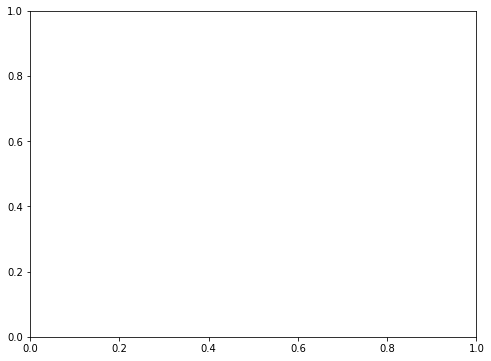

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.legend(fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.set_xlabel('epochs', fontsize=16)

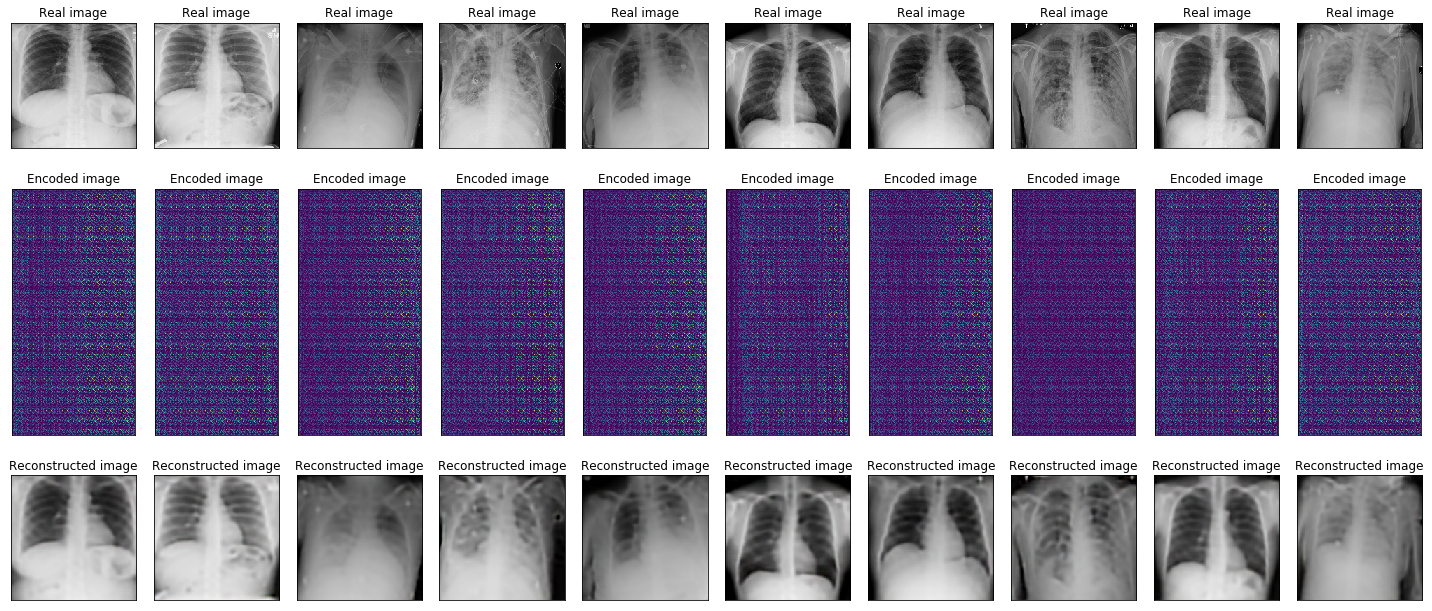

In [20]:
plt.figure(figsize=(20, 10))
for i in range(10):
    ax = plt.subplot(3, 10, i+1)
    ax.imshow(X_test[i])
    plt.xticks(())
    plt.yticks(())
    ax.set_title('Real image')
    ax2 = plt.subplot(3, 10, i + 1 + 10)
    ax2.imshow(encoder_imgs[i].reshape(23*8, 23*16).T)
    plt.xticks(())
    plt.yticks(())
    ax2.set_title('Encoded image')
    ax3 = plt.subplot(3, 10, i + 1 + 2*10)
    ax3.imshow(decoder_imgs[i])
    plt.xticks(())
    plt.yticks(())
    ax3.set_title('Reconstructed image')
    plt.tight_layout()
    plt.savefig('Figures/Autoencoder_Reconstruction.png', dpi=200)